<a href="https://colab.research.google.com/github/MatteoOnger/NLP_Project/blob/main/NLP_EED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Project: Enron Email Dataset**

*   **Author:** Matteo Onger
*   **Date:** December 2024

**Dataset documentation**:
*   [Enron email dataset](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset)

**Extra documentation**:
*   [POS](https://universaldependencies.org/u/pos/)
*   [SpaCy - English](https://spacy.io/models/en#en_core_web_sm)

**Notes**:
*   Only basic parameters can be changed via the forms.

In [1]:
# ---- LIBRARIES ----
import email
import gensim
import gensim.downloader
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy

from enum import Enum
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from spacy.language import Language
from tqdm.notebook import tqdm
from typing import Any, Literal


# init spacy
flag_gpu = spacy.prefer_gpu()
print(f"GPU available:{flag_gpu}")

# init tpqdm
tqdm.pandas()

GPU available:False


In [ ]:
# ---- FUNCTIONS ----
def extract_fields(msg :email.message, fields :list[str]|None=None) -> dict[str, str]:
    """
    This function extracts the required fields from the given email message.
    If field is ``None``, all the available ones are returned.

    Parameters
    ----------
    msg : email.message
        Email message.
    fields : list | None, optional
        The fields to extract, by default ``None``.

    Returns
    -------
    :dict[str, str]
        A dictionary ``{field_name:field_value}`` containing the fields extracted is returned.

    Notes
    -----
    - If  ``fields`` is ``None``, all the available fields are extracted.
    - Fields must be in lower case.
    """
    res = dict()

    if fields is None:
        res = {str.lower(key):msg[key] for key in msg.keys()}
    else:
        res = {str.lower(key):msg[key] for key in msg.keys() if str.lower(key) in fields}

    if fields is None or "content" in fields:
        parts = list()
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                parts.append(part.get_payload())
        res["content"] = "".join(parts)
    return res


def identity_tokenizer(text):
    """
    Returns ``text`` as it is.
    """
    return text


def remove(lt :list, value :Any) -> list[Any]:
    """
    Returns a copy of the given list without the given value.

    Parameters
    ----------
    lt : list
        List to modify.
    value : Any
        Value to remove.

    Returns
    -------
    :list
        A new list without ``value``.
    """
    lt_copy = list(lt)
    lt_copy.remove(value)
    return lt_copy


def split_email_addresses(addresses :str) -> list[str]:
    """
    Extracts the email addresses contained in the provided string.

    Parameters
    ----------
    addresses : str
        String containing email addresses.

    Returns
    -------
    :list[str]
        List of strings that are the email addresses found.

    Notes
    -----
    - If ``addresses`` is not a string, an empty list is returned.
    """
    if isinstance(addresses, str):
        addrs = re.findall(r'[\w.+-]+@[\w-]+\.[\w.-]+', addresses)
    else:
        addrs = list()
    return addrs

In [ ]:
# ---- CLASSES ----
class Preprocessor():
    """
    This class implements a simple preprocessor to split documents into lists of tokens.
    It is mainly based on spaCy.
    """

    class CREIL(Enum):
        """
        Common regex of invalid lines.
        """
        HEADER = r"^\s*(?:-{5,}|.*-{5,}|from:|to:|cc:|ccn:|sent by:|subject:).*$"
        """
        Removes (forwarded, etc.) email header and blank lines.
        """

    class CREIT(Enum):
        """
        Common regex of invalid tokens.
        """
        ALPHA2 = r"^(?:.*[^a-z]{1,}.*|.)$"
        """
        Only tokens of two or more characters consisting only of alphabetic characters are retained.
        """
        ALPHA_2 = r"^(?:.*[^a-z_-]{1,}.*|.)$"
        """
        Only tokens of two or more characters consisting only of alphabetic characters, and high or low dashes, are retained.
        """
        ALPHANUM = r".*(?:\W|_).*"
        """
        Removes tokens that contain non-alphanumeric characters, '_' included.
        """


    @Language.component("lower_case_lemmas")
    def _lower_case_lemmas(doc :spacy.tokens.Doc) -> spacy.tokens.Doc:
        """
        Changes the capitalization of the lemmas to lowercase.

        Parameters
        ----------
        doc : spacy.tokens.Doc
            Doc to modify.

        Returns
        -------
        :spacy.tokens.Doc
            Doc modified.
        """
        for token in doc :
            token.lemma_ = token.lemma_.lower()
        return doc


    def __init__(
        self,
        case_sensitive :bool=True,
        lemmatize :bool=False,
        noun_chunks :bool=False,
        keep_stopwords :bool=True,
        extend_stopwords :set[str]|None=None,
        regex_flags :int=0,
        regex_invalid_line :'str|Preprocessor.CREIL|None'=None,
        regex_invalid_tokens :'str|Preprocessor.CREIT|None'=None,
        ent_to_keep :set[str]|None=None,
        ent_to_rm :set[str]|None=None,
        pos_to_keep :set[str]|None=None,
        pos_to_rm :set[str]|None=None,
    ):
        """
        Parameters
        ----------
        case_sensitive : bool, optional
            If ``False``, all returned tokens are lowercase, by default ``True``.
        lemmatize : bool, optional
            If ``True``, tokens are lemmatized, by default ``False``.
        noun_chunks : bool, optional
            If ``True``, chunk nouns are merged, by default ``False``.
        keep_stopwords : bool, optional
            If ``True``, stop words are kept, by default ``True``.
        extend_stopwords : set[str] | None, optional
            List of stop words to add, by default ``None``.
        regex_flags : int, optional
            Flags of the regular expressions, by default ``0``.
        regex_invalid_line : str | Preprocessor.CREIL | None, optional
            Regex to mark lines that must be excluded, by default ``None``.
        regex_invalid_tokens : str | Preprocessor.CREIT | None, optional
            Regex to mark tokens that must be excluded, by default ``None``.
        ent_to_keep : set[str] | None, optional
            Only tokens marked with one of these entity tags are kept,
            by default all tokens are retained.
        ent_to_rm : set[str] | None, optional
            Tokens marked with one of these entity tags are removed,
            by default all tokens are retained.
        pos_to_keep : set[str] | None, optional
            Only tokens marked with one of these POS tags are kept,
            by default all tokens are retained.
        pos_to_rm : set[str] | None, optional
            Tokens marked with one of these POS tags are removed,
            by default all tokens are retained.
        """
        self.nlp = spacy.load('en_core_web_sm')

        # update nlp piepline
        if not lemmatize and not noun_chunks:
            self.nlp.remove_pipe("lemmatizer")
            if ent_to_keep is None and ent_to_rm is None and pos_to_keep is None and pos_to_rm is None:
                self.nlp.remove_pipe("tagger")
                self.nlp.remove_pipe("parser")
                self.nlp.remove_pipe("attribute_ruler")
                self.nlp.remove_pipe("ner")
        if noun_chunks:
            self.nlp.add_pipe("merge_noun_chunks")
        if lemmatize and not case_sensitive:
            self.nlp.add_pipe("lower_case_lemmas", name="lower_case_lemmas")

        # standard regex
        self.regex_empty_line = r"^\s*$"
        self.regex_endline_1 = r"(=20\n)"
        self.regex_endline_2 = r"(=\n)"

        self.pattern_empty_line = re.compile(self.regex_empty_line, regex_flags)
        self.pattern_endline_1 = re.compile(self.regex_endline_1, regex_flags)
        self.pattern_endline_2 = re.compile(self.regex_endline_2, regex_flags)

        # save fields
        self.case_sensitive = case_sensitive
        self.noun_chunks = noun_chunks
        self.lemmatize = lemmatize
        self.keep_stopwords = keep_stopwords
        self.extend_stopwords = extend_stopwords
        self.regex_flags = regex_flags
        self.regex_invalid_line = regex_invalid_line.value if isinstance(regex_invalid_line, Preprocessor.CREIL) else regex_invalid_line
        self.regex_invalid_tokens = regex_invalid_tokens.value if isinstance(regex_invalid_tokens,  Preprocessor.CREIT) else regex_invalid_tokens
        self.ent_to_keep = ent_to_keep
        self.ent_to_rm = ent_to_rm
        self.pos_to_keep = pos_to_keep
        self.pos_to_rm = pos_to_rm

        # assemble the condition that tokens/lines must satisfy
        self.conditions = list()
        if not keep_stopwords:
            self.conditions.append(lambda x: not x.is_stop)
            if extend_stopwords is not None:
                if lemmatize:
                    self.conditions.append(lambda x: x.lemma_ not in extend_stopwords)
                else:
                    self.conditions.append(lambda x: x.text not in extend_stopwords if case_sensitive else x.text.lower() not in extend_stopwords)
        if ent_to_keep is not None:
            self.conditions.append(lambda x: x.ent_type_ in ent_to_keep)
        if ent_to_rm is not None:
            self.conditions.append(lambda x: x.ent_type_ not in ent_to_rm)
        if pos_to_keep is not None:
            self.conditions.append(lambda x: x.pos_ in pos_to_keep)
        if pos_to_rm is not None:
            self.conditions.append(lambda x: x.pos_ not in pos_to_rm)

        if regex_invalid_line is not None:
            self.pattern_invalid_line = re.compile(self.regex_invalid_line, regex_flags)
        if regex_invalid_tokens is not None:
            self.pattern_invalid_tokens = re.compile(self.regex_invalid_tokens, regex_flags)
            self.conditions.append(lambda x: not self.pattern_invalid_tokens.match(x.text))
        return


    def preprocess(self, document :str) -> list[str]:
        """
        Applies the preprocessing procedure to the given document.

        Parameters
        ----------
        document : str
            Document to process.

        Returns
        -------
        :list[str]
            List of tokens representing the document.
        """
        # MIME protocol for base64, the max line length in the encoded data is 76 characters
        # an '=' sign at the end of an encoded line is used to tell the decoder that the line is to be continued,
        # while an '=20' sign is used to tell the line ends
        document = self.pattern_endline_1.sub("\n", document)
        document = self.pattern_endline_2.sub("", document)

        # read the document line by line and remove the invalid ones that are:
        # - blank lines
        # - lines that match the given regex <self.regex_invalid_line>
        # - lines preceded by invalid non-white lines
        prev = True
        filtered_document = list()
        for line in document.splitlines():
            if self.pattern_empty_line.match(line):
                prev = True
            elif prev and (self.regex_invalid_line is None or not self.pattern_invalid_line.match(line)):
                filtered_document.append(line)
            else:
                prev = False

        # replace all withespaces with a single whitespace
        document = re.sub(r"\s{1,}", " ", "\n".join(filtered_document))

        # tokenize, etc. using spaCy
        doc = self.nlp(document)
        if self.lemmatize:
            tokens = [tk.lemma_ for tk in doc if all(f(tk) for f in self.conditions)]
        else:
            if self.case_sensitive:
                tokens = [tk.text for tk in doc if all(f(tk) for f in self.conditions)]
            else:
                tokens = [tk.text.lower() for tk in doc if all(f(tk) for f in self.conditions)]
        return tokens



class KMeansHelper():
    """
    This class is based on the module ``sklearn.cluster.KMeans`` and
    provides some heuristics to estimate the best number of clusters.
    """

    def __init__(
        self,
        init :Literal['k-means++', 'random']="k-means++",
        n_init :int|str="auto",
        max_iter :int=300,
        random_state :int|None=None
    ):
        """
        Parameters
        ----------
        init : Literal['k-means++', 'random'], optional
            Method for initialization, by default ``'k-means++'``:
            - ``'k-means++'``: selects initial cluster centroids using sampling based on an empirical probability distribution
            of the points' contribution to the overall inertia. This technique speeds up convergence.
            The algorithm implemented is greedy k-means++. It differs from the vanilla k-means++ by making several trials
            at each sampling step and choosing the best centroid among them.
            - ``'random'``: choose n_clusters observations at random from data for the initial centroids.
        n_init : int | str, optional
            Number of times the k-means algorithm is run with different centroid seeds.
            By default ``n_init='auto'``, the number of runs depends on the value of init:
            10 if using ``init='random'``; 1 if using ``init='k-means++'``.
        max_iter : int, optional
            Maximum number of iterations of the k-means algorithm for a single run, by default ``300``.
        random_state : int | None, optional
            Determines random number generation for centroid initialization. Use an int to make the randomness deterministic,
            by default ``None``.
        """
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        return


    def elbow_method(self, X :np.ndarray, min_K :int, max_K :int) -> dict[int, int]:
        """
        Returns and draws the inertia as the number of clusters changes.
        This heuristic is used to determine the number of clusters in a data set ``X``.

        Parameters
        ----------
        X : np.ndarray
            New data to transform.
        min_K : int
            Minimum number of clusters.
        max_K : int
            maximum number of clusters.

        Returns
        -------
        :dict[int, int]
            A dictionary containing the SSE for every possible number of clusters
            between ``min_K`` and ``max_K``.
        """
        sse = {}
        for k in range(min_K, max_K):
            kmeans = KMeans(n_clusters=k, init=self.init, n_init=self.n_init, max_iter=self.max_iter, random_state=self.random_state).fit(X)
            sse[k] = kmeans.inertia_

        plt.figure()
        plt.plot(list(sse.keys()), list(sse.values()), marker='*')
        plt.title("Elbow method")
        plt.xlabel("Number of cluster (K)")
        plt.ylabel("SSE")
        plt.show()
        return sse


    def fit_predict(self, X :np.ndarray, K :int) -> tuple[np.ndarray, np.ndarray]:
        """
        Compute cluster centers and predict cluster index for each sample.

        Parameters
        ----------
        X : np.ndarray
            New data to transform.
        K : int
            Number of clusters.

        Returns
        -------
        :tuple[np.ndarray, np.ndarray]
            Index of the cluster each sample belongs to and the centroids.
        """
        kmeans = KMeans(n_clusters=K, init=self.init, n_init=self.n_init, max_iter=self.max_iter, random_state=self.random_state)
        clusters = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        return clusters, centroids


    def silhouette_score(self, X :np.ndarray, min_K :int, max_K :int) -> dict[int, int]:
        """
        Returns the silhouette score [-1, 1] as the number of clusters changes.
        This heuristic is used to determine the number of clusters in the dataset ``X``.

        Parameters
        ----------
        X : np.ndarray
            New data to transform.
        min_K : int
            Minimum number of clusters.
        max_K : int
            maximum number of clusters.

        Returns
        -------
        :dict[int, int]
            A dictionary containing the silhouette score for every possible number of clusters
            between ``min_K`` and ``max_K``.
        """
        sc = {}
        print("Number of clusters:")
        for k in range(min_K, max_K):
            kmeans = KMeans(n_clusters=k, init=self.init, n_init=self.n_init, max_iter=self.max_iter, random_state=self.random_state).fit(X)
            sc[k] = silhouette_score(X, kmeans.labels_, metric='euclidean')

            s = f" - K:{k} => Silhouette coeff.: {sc[k]}"
            if (k != min_K) and (sc[k] < sc[k-1]):
                s += " *"
            print(s)
        return sc



class myDoc2vec():
    """
    This class maps a document to a vector using a weighted average of the vectors
    associated with the tokens that constitute the document under consideration.
    """

    def __init__(self,
        w2v :gensim.models.KeyedVectors,
        tfidf_vectorizer :TfidfVectorizer,
        exp_a :float=1.0,
        exp_b :float=1.0,
        eps_type :Literal['abs', 'pc']="abs",
        eps :float=0.0
    ):
        """
        Parameters
        ----------
        w2v : gensim.models.KeyedVectors
            Word vectors to use.
        tfidf_vectorizer : TfidfVectorizer
            Vectorizer to use to compute the TF-IDF scores.
        exp_a : float, optional
            Exponent of the TF-IDF term, by default ``1.0``.
        exp_b : float, optional
            Exponent of the similarity term, by default ``1.0``.
        eps_type : Literal['abs', 'pc'], optional
            Type of threshold:
            - ``'abs'``: set weights less than ``eps`` to zero.
            - ``'pc'``: keep only the largest n weights to cover at least ``eps`` (%) of the total,
            set the others to zero.
        eps : float, optional
            Threshold, by default ``0.0``.
        """
        self.w2v = w2v
        self.tfidf_vectorizer = tfidf_vectorizer
        self.exp_a = exp_a
        self.exp_b = exp_b
        self.eps_type = eps_type
        self.eps = eps
        return


    def transform(self, tokenized_corpus :list[list[str]], save :bool=False) -> np.ndarray:
        """
        For each document in the corpus, the function computes a vector representing it.
        The vectors produced lie in the same space defined by the word vectors provided
        during the object initialization.

        Parameters
        ----------
        tokenized_corpus : list[list[str]]
            Corpus, already tokenized, to be analyzed.
        save : bool, optional
            For debugging, if ``True``,
            the weights of each token in each document are saved in ``self._weights``, by default ``False``.

        Returns
        -------
        :np.ndarray
            A vector for each document.
        """
        corpus_size = len(tokenized_corpus)
        corpus_weights = self.get_weights(tokenized_corpus)

        if save:
            self._weights = corpus_weights
        else:
            self._weights = None

        res = np.zeros((corpus_size, self.w2v.vector_size))
        for i in range(corpus_size):
            # list of unique tokens in i-th doc
            # duplicated tokens are considered only once
            tokens = list(corpus_weights[i].keys())

            # weight of each token
            weights = list(corpus_weights[i].values())

            # weighted mean
            if len(tokens) != 0:
                res[i] = self.w2v.get_mean_vector(tokens, weights=weights)
        return res


    def get_weights(self, tokenized_corpus :list[list[str]]) -> list[dict[str, float]]:
        """
        Computes the weight of each token in each document.
        The weight of the token tk in document doc is computed as follows:
        weight := tfidf(tk, doc)**exp_a * average similarity(tk, other tokens in doc)**exp_b.
        The weights of a document are then filtered using the threshold and normalised to sum to one.

        Parameters
        ----------
        tokenized_corpus : list[list[str]]
            Corpus, already tokenized, to be analyzed.

        Returns
        -------
        :list[dict[str, float]]
            The weight of each token in each document.
        """
        corpus_size = len(tokenized_corpus)

        tfidf_corpus = self.tfidf_vectorizer.fit_transform(tokenized_corpus)
        tf_corpus = normalize(tfidf_corpus / self.tfidf_vectorizer.idf_, norm=self.tfidf_vectorizer.norm)

        corpus_weights = list()
        for i in range(corpus_size):
            # term frequency of tokens in i-th document
            tf_doc = tf_corpus[i].data

            # list of unique tokens in i-th document and their position in the tfidf matrix
            # duplicated tokens are considered only once
            token_idxs = tf_corpus[i].nonzero()[1]
            tokens = list(
                self.tfidf_vectorizer.get_feature_names_out()[token_idxs]
            )

            # compute the weight of each token in i-th document
            if len(tokens) == 0:
                corpus_weights.append({})
            elif len(tokens) == 1:
                corpus_weights.append({tokens[0]:1.0})
            else:
                weights = np.zeros(len(tokens))

                for j, (idx, tk) in enumerate(zip(token_idxs, tokens)):
                    weights[j] = (
                        tfidf_corpus[i, idx]**self.exp_a
                    ) * (
                        np.average(1 - self.w2v.distances(tk, remove(tokens, tk)) / 2, weights=np.delete(tf_doc, j))**self.exp_b
                    )

                    if self.eps_type == "abs" and weights[j] < self.eps:
                        weights[j] = 0.0

                if self.eps_type == "pc":
                    weights = weights / np.sum(weights)
                    sorted_weight_idxs = np.argsort(weights)[::-1]
                    cumsum_weights = np.cumsum(weights[sorted_weight_idxs])

                    for j in range(1, weights.size):
                        if cumsum_weights[j-1] >= self.eps:
                            weights[sorted_weight_idxs[j]] = 0.0

                corpus_weights.append(
                    dict(zip(tokens, normalize([weights], norm="l1")[0]))
                )
        return corpus_weights


    def get_most_similar(self, tokenized_corpus :list[list[str]], topn :int=10) -> list[list[tuple[str, float]]]:
        """
        Equivalent to calling the function ``self.w2v.most_similar`` on the vectors
        returned by ``self.transform``.

        Parameters
        ----------
        tokenized_corpus : list[list[str]]
            Corpus, already tokenized, to be analyzed.
        topn : int, optional
            Number of most similar keys to return, by default ``10``.

        Returns
        -------
        :list[list[tuple[str, float]]]
            The ``top-n`` most similar keys found for each document.

        Notes
        -----
        - Finding the most similar keys for each vector is a slow operation;
        if you are only interested in a few documents, it is better to call ``self.transform``
        and then call ``self.w2v.most_similar`` only on the documents of interest.
        """
        corpus_size = len(tokenized_corpus)
        vec_corpus = self.transform(tokenized_corpus)

        res = list()
        for i in range(corpus_size):
            res.append(
                self.w2v.most_similar(vec_corpus[i], topn=topn)
            )
        return res

## Dataset

In [ ]:
# ---- DATASET ----
# download latest version
path = kagglehub.dataset_download("wcukierski/enron-email-dataset")
print(f"Path to dataset files: {path}")

# read the dataset
df = pd.read_csv(path + "/emails.csv")

# from string to email.message
df["message"] = df["message"].apply(lambda x: email.message_from_string(x))

# extract main fields
df = df.join(
    df.apply(
        lambda row: extract_fields(row.message, ["message-id", "date", "from", "to", "subject", "content"]),
        axis='columns',
        result_type='expand'
    )
)

# drop unused columns and duplicated messages
df.drop(columns=["message"], inplace=True)
df.drop_duplicates(["content"], keep="first", inplace=True)

# split addresses into a list of strings
df["from"] = df["from"].apply(
    lambda x: split_email_addresses(x),
)
df["to"] = df["to"].apply(
    lambda x: split_email_addresses(x),
)

100%|██████████| 358M/358M [00:03<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/wcukierski/enron-email-dataset/versions/2


## Content's ...

### Corpus

In [ ]:
# @markdown Minimum and maximum length (in characters) of emails to be analyzed:
min_len =  1_000  # @param {type: "number"}
max_len = 20_000  # @param {type: "number"}
# @markdown ---

corpus = df[df["content"].apply(lambda x: len(x)).between(min_len, max_len)]

display(corpus)
idx = np.random.randint(0, len(corpus))
print(f"\nRandom exemple [iloc:{idx}, loc:{corpus.index[idx]}] =>\n{corpus.iloc[idx, 6]}")

,file,message-id,date,from,to,subject,content
9,allen-p/_sent_mail/102.,<30795301.1075855687494.JavaMail.evans@thyme>,"Mon, 16 Oct 2000 06:44:00 -0700 (PDT)",[phillip.allen@enron.com],[zimam@enron.com],FW: fixed forward or other Collar floor gas pr...,---------------------- Forwarded by Phillip K ...
12,allen-p/_sent_mail/105.,<13116875.1075855687561.JavaMail.evans@thyme>,"Mon, 9 Oct 2000 07:16:00 -0700 (PDT)",[phillip.allen@enron.com],[keith.holst@enron.com],Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...
13,allen-p/_sent_mail/106.,<2707340.1075855687584.JavaMail.evans@thyme>,"Mon, 9 Oct 2000 07:00:00 -0700 (PDT)",[phillip.allen@enron.com],[keith.holst@enron.com],Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...
18,allen-p/_sent_mail/110.,<12759088.1075855687671.JavaMail.evans@thyme>,"Tue, 3 Oct 2000 09:30:00 -0700 (PDT)",[phillip.allen@enron.com],[pallen70@hotmail.com],Westgate,---------------------- Forwarded by Phillip K ...
23,allen-p/_sent_mail/115.,<15294346.1075855687778.JavaMail.evans@thyme>,"Thu, 28 Sep 2000 06:17:00 -0700 (PDT)",[phillip.allen@enron.com],[lkuch@mh.com],San Juan Index,---------------------- Forwarded by Phillip K ...
...,...,...,...,...,...,...,...
517386,zufferli-j/sent_items/86.,<24771639.1075842029703.JavaMail.evans@thyme>,"Tue, 11 Dec 2001 09:48:22 -0800 (PST)",[john.zufferli@enron.com],[jzufferli@shaw.ca],FW: hello,"\n\n -----Original Message-----\nFrom: \t""John..."
517389,zufferli-j/sent_items/89.,<24358278.1075842029773.JavaMail.evans@thyme>,"Fri, 7 Dec 2001 07:36:04 -0800 (PST)",[john.zufferli@enron.com],[ken.gardner@powerpool.ab.ca],RE: Supply Shortfall Procedures,\nEnron is willing to perform the operation un...
517390,zufferli-j/sent_items/9.,<8033934.1075842027777.JavaMail.evans@thyme>,"Tue, 5 Feb 2002 15:02:45 -0800 (PST)",[john.zufferli@enron.com],[john.postlethwaite@enron.com],RE: EOL - Multiple Trading Books (URGENT),I will have 4 books:\n\nCAND-MGMT-BAS for all ...
517392,zufferli-j/sent_items/91.,<23829224.1075842029820.JavaMail.evans@thyme>,"Mon, 3 Dec 2001 05:53:41 -0800 (PST)",[john.zufferli@enron.com],"[nicole.laporte@enron.com, paul.dunsmore@enron...",RE: Counterparty List,"Nicole and everyone, I think the directory is ..."



Random exemple [iloc:72532, loc:368350] =>
Anne

Can we discuss this tomorrow when I meet from 2:30 to 4:30

dq
 -----Original Message-----
From: 	ann.s.chen@accenture.com@ENRON  
Sent:	Wednesday, November 07, 2001 3:30 PM
To:	Quigley, Dutch
Subject:	Questions regarding storage

Hi there Dutch!

How are you? Hope you're doing well.

We having been working on a storage problem that Philip as given us the
framework for.  In working out the details, we've come across a few
questions that we know you can help us answer. I've included Philip's
description of this problem in the word doc below, just for reference.

1) In Philip's document, he lists discount factors over the months.  We
understand that since the users are making storage decisions and hedging
future months, they need to take time value of money into account.  What is
actually being discounted? Is it NYMEX? Is it prices of the instruments?
How does that factor into user's storage decisions?

2) In our problem, we ask the user 

### Tokenizer

In [ ]:
pp = Preprocessor(
    case_sensitive = False,
    lemmatize = True,
    noun_chunks = False,
    keep_stopwords = False,
    extend_stopwords = {"alot", "cell", "email", "fax", "fyi", "mail", "hereto", "link", "lot",
                        "number", "pm", "recipient", "sender", "thank", "thanks", "thereto", "thing", "time"},
    regex_flags = re.IGNORECASE,
    regex_invalid_line = Preprocessor.CREIL.HEADER,
    regex_invalid_tokens = Preprocessor.CREIT.ALPHA2,
    pos_to_keep = {"NOUN"},
    ent_to_rm = {"DATE", "TIME"}
)

tokenized_corpus = list(corpus["content"].progress_apply(pp.preprocess))

  0%|          | 0/103050 [00:00<?, ?it/s]

In [ ]:
print(f"Random exemple [iloc:{idx}, loc:{corpus.index[idx]}] =>\n{tokenized_corpus[idx]}")

Random exemple [iloc:72532, loc:368350] =>
['tomorrow', 'dq', 'storage', 'problem', 'framework', 'detail', 'question', 'description', 'problem', 'word', 'reference', 'document', 'discount', 'factor', 'user', 'storage', 'decision', 'value', 'money', 'account', 'price', 'instrument', 'factor', 'user', 'storage', 'decision', 'problem', 'user', 'storage', 'schedule', 'instrument', 'position', 'storage', 'scenario', 'position', 'risk', 'bucket', 'user', 'hedging', 'instrument', 'risk', 'area', 'instrument', 'storage', 'scenario', 'position', 'storage', 'decision', 'risk', 'bucket', 'position', 'thought', 'position', 'storage', 'user', 'type', 'instrument', 'risk', 'advance', 'help', 'file', 'storage', 'message', 'information', 'error', 'original', 'use', 'file']


### TF-IDF

In [ ]:
# @markdown Skip tokens that do not have a relative document frequency in this range:
min_df = 0.01  # @param {type: "number"}
max_df = 1.00  # @param {type: "number"}
# @markdown ---

tfidf_vectorizer =  TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, min_df=min_df, max_df=max_df)
tfidf_corpus = tfidf_vectorizer.fit_transform(tokenized_corpus)

pd.DataFrame(tfidf_corpus.toarray(), index=corpus.index, columns=tfidf_vectorizer.get_feature_names_out())

#### K-Means

In [ ]:
# use elbow method and silhouette score to estimate the number of clusters
kmeans = KMeansHelper()

_ = kmeans.elbow_method(tfidf_corpus, 2, 12)
_ = kmeans.silhouette_score(tfidf_corpus, 2, 12)

In [ ]:
# number of clusters
K = 6
# number of tokens with the highest tf-idf score to show per cluster
W = 5

kmeans = KMeansHelper()
clusters, centroids = kmeans.fit_predict(tfidf_corpus, K)

# for each centroid, sort the token indexes according to their tf-idf score (descending order)
sorted_token_idxs = (np.argsort(centroids, axis=1)[:, ::-1])
# find the index of <W> tokens with the highest tf-idf score that are not among
# the <W> tokens with the highest tf-idf score in other clusters
unique_main_token_idxs = np.full((K, W), -1)

for k in range(K):
    counter = 0
    for tk_idx in sorted_token_idxs[k]:
        if tk_idx not in np.delete(sorted_token_idxs[:, :W], k, axis=0) and tk_idx not in unique_main_token_idxs:
            unique_main_token_idxs[k, counter] = tk_idx
            counter += 1
        if counter == W:
            break

    main_tokens = tfidf_vectorizer.get_feature_names_out()[sorted_token_idxs[k, :W]]
    unique_main_tokens = tfidf_vectorizer.get_feature_names_out()[unique_main_token_idxs[k]]
    doc_idxs_in_cluster = np.flatnonzero(clusters == k)

    print(f"Cluster {k} =>")
    print(f" - size: {len(doc_idxs_in_cluster)}")
    print(f" - main tokens: {main_tokens}")
    print(f" - unique main tokens: {unique_main_tokens}")
    print(f" - random samples: {np.random.choice(doc_idxs_in_cluster, 3)}")
print()

### LDA

In [ ]:
# @markdown Number of topics:
T = 10  # @param {type: "number"}
# @markdown ---

# id to word
id2word = gensim.corpora.Dictionary(tokenized_corpus)

# term frequency of tokens in i-th document
tf_corpus = [id2word.doc2bow(tk) for tk in tokenized_corpus]

lda = gensim.models.LdaMulticore(corpus=tf_corpus, id2word=id2word, num_topics=T, passes=10)
for t in range(T):
    print(f"Topic {t} =>")
    print(lda.print_topic(t, topn=5))

### BERTopic

In [ ]:
# download libraries
!pip install bertopic
!pip install bertopic[gensim]

In [ ]:
from bertopic import BERTopic

model = BERTopic(nr_topics=10, verbose=True)
topics, probabilities = model.fit_transform(corpus["content"].to_list())

In [ ]:
# get most frequent topics
topic_freq = model.get_topic_freq()
topic_freq.head(10)

In [ ]:
# get most impo words for of the most frquent topic
model.get_topic(topic_freq.index[0])

In [ ]:
# visualize the clusters
model.visualize_topics()

### myDoc2vec

In [ ]:
# @markdown If True, the Word2vec model is trained using the corpus, otherwise a pre-trained model is downloaded:
train = True    # @param {type: "boolean"}
# @markdown The norm that must be used:
norm = "l2" # @param ["l1","l2"]
# @markdown Word vector size:
wv_size = 100    # @param {type: "number"}
# @markdown Skip tokens that do not have a relative document frequency in this range:
min_df = 0.01  # @param {type: "number"}
max_df = 1.00  # @param {type: "number"}
# @markdown ---

# compute / download word vectors
word2vector :np.ndarray
if train:
    model = gensim.models.Word2Vec(tokenized_corpus, vector_size=wv_size)
    word2vector = model.wv
else:
    word2vector = gensim.downloader.load("word2vec-google-news-300")

# vectorizer used to compute the tf-idf score
tfidf_vectorizer =  TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, norm=norm, min_df=min_df, max_df=max_df).fit(tokenized_corpus)

# define the vocabolary shared by the word2vect model and the tf-idf vectorizer
count = 0
voc = set(tfidf_vectorizer.get_feature_names_out())
for tk in tfidf_vectorizer.get_feature_names_out():
    if tk not in word2vector.key_to_index:
        voc.remove(tk)
        count += 1
print(f"Tokens removed: {count}")

Tokens removed: 0


In [ ]:
# @markdown Weights formula's parameters:
exp_a = 2.0  # @param {type: "number"}
exp_b = 3.0  # @param {type: "number"}
eps_type = "pc" # @param ["abs", "pc"]
eps = 0.95  # @param {type: "number"}
# @markdown ---

d2v = myDoc2vec(
    word2vector,
    TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, norm=norm, vocabulary=voc),
    exp_a = exp_a,
    exp_b = exp_b,
    eps_type = eps_type,
    eps = eps
)

vec_corpus = d2v.transform(tokenized_corpus, save=True)

In [ ]:
# random example
idx = np.random.randint(0, len(tokenized_corpus))

print(f"Random exemple [iloc:{idx}, loc:{corpus.index[idx]}] =>")
print(f"{corpus.iloc[idx, 6]}")
print("------------------------------------------")
print(f" - tokenized document: {tokenized_corpus[idx]}")
print(f" - token weights: {d2v._weights[idx]}")
print(f" - most similar: {d2v.w2v.most_similar(vec_corpus[idx], topn=5)}")

Random exemple [iloc:78725, loc:400299] =>
Fall Recruiting for Associates & Analysts is here once again and you have been elected to participate in our Super Saturday Event!  

This year, the onsite interviews are scheduled for two Saturdays in November.  On each Saturday, the top 9 - 12 candidates from our local schools will be present.  This will help tremendously with our cross-calibration process.  The dates and schools are as follows:

	Saturday, November 10, candidates will be drawn from:  
		University of Portland
		University of Oregon
		University of Washington
		Washington State University

	Saturday, November 17, candidates will be drawn from:
		Portland State University
		UC Davis (Associate candidates only)
		Oregon State University

We will need you to participate in at least one of these Saturday events.  We will also need 5-6 people to overlap and attend both Saturdays, so please volunteer if you are able.  (PS:  If we don't have enough overlap, we will have to begin "d

#### K-Means

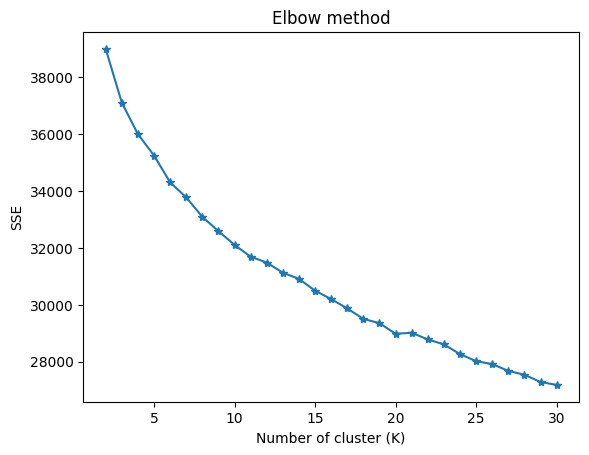

Number of clusters:
 - K:2 => Silhouette coeff.: 0.0691966656271185
 - K:3 => Silhouette coeff.: 0.06631497401048991 *
 - K:4 => Silhouette coeff.: 0.05769233690155292 *
 - K:5 => Silhouette coeff.: 0.053834108126142324 *
 - K:6 => Silhouette coeff.: 0.05836735921007025
 - K:7 => Silhouette coeff.: 0.05999869843118298
 - K:8 => Silhouette coeff.: 0.0613232411568122
 - K:9 => Silhouette coeff.: 0.06289794928197269
 - K:10 => Silhouette coeff.: 0.058612788356559475 *
 - K:11 => Silhouette coeff.: 0.056488179951885244 *
 - K:12 => Silhouette coeff.: 0.061726877217419644
 - K:13 => Silhouette coeff.: 0.06537328453871767
 - K:14 => Silhouette coeff.: 0.061062199228022036 *
 - K:15 => Silhouette coeff.: 0.06376356402066628
 - K:16 => Silhouette coeff.: 0.06538546167462111
 - K:17 => Silhouette coeff.: 0.06589939032276007
 - K:18 => Silhouette coeff.: 0.05622431798494038 *
 - K:19 => Silhouette coeff.: 0.0697305193989901
 - K:20 => Silhouette coeff.: 0.07258399920677087
 - K:21 => Silhouette 

In [ ]:
# use elbow method and silhouette score to estimate the number of clusters
kmeans = KMeansHelper()

_ = kmeans.elbow_method(vec_corpus, 2, 31)
_ = kmeans.silhouette_score(vec_corpus, 2, 31)

In [ ]:
# number of clusters
K = 25  # PARAM
# number of most similar tokens to show per cluster
W = 5   # PARAM

kmeans = KMeansHelper(n_init=100, max_iter=10000)
clusters, centroids = kmeans.fit_predict(vec_corpus, K)

# print cluster found
for k in range(K):
    doc_idxs_in_cluster = np.flatnonzero(clusters == k)

    # cosine distance
    dists = 1 - d2v.w2v.cosine_similarities(centroids[k], vec_corpus[doc_idxs_in_cluster])
    min_dist, min_idx = np.nanmin(dists), doc_idxs_in_cluster[np.nanargmin(dists)]
    max_dist, max_idx = np.nanmax(dists), doc_idxs_in_cluster[np.nanargmax(dists)]

    print(f"Cluster {k} =>")
    print(f" - size: {len(doc_idxs_in_cluster)}")
    print(f" - closest tokens: {d2v.w2v.most_similar(centroids[k], topn=W)}")
    print(f" - closest doc ({round(min_dist,4)}): {min_idx}")
    print(f" - farthest doc ({round(max_dist,4)}): {max_idx}")
    print(f" - random samples: {np.random.choice(doc_idxs_in_cluster, 10)}")
print()

Cluster 0 =>
 - size: 5119
 - closest tokens: [('gas', 0.8067867755889893), ('capacity', 0.6819394826889038), ('pipeline', 0.6525752544403076), ('facility', 0.642233669757843), ('peaking', 0.6371981501579285)]
 - closest doc (0.0656): 57626
 - farthest doc (0.7857): 12083
 - random samples: [47650 61634 36032 28263 73838 28445 64461 59389 24528 37658]
Cluster 1 =>
 - size: 7586
 - closest tokens: [('group', 0.7125187516212463), ('objective', 0.7121394276618958), ('effort', 0.6979478001594543), ('involvement', 0.6659373044967651), ('coordination', 0.6589601635932922)]
 - closest doc (0.0813): 64878
 - farthest doc (0.7126): 42863
 - random samples: [14319 88507 21526 83104 44214 21228 88511 55483 85545 31947]
Cluster 2 =>
 - size: 4441
 - closest tokens: [('lunch', 0.7143901586532593), ('guy', 0.6768869161605835), ('dinner', 0.6762217283248901), ('touch', 0.6496067643165588), ('town', 0.6426363587379456)]
 - closest doc (0.1202): 15084
 - farthest doc (0.8221): 59638
 - random samples: 

/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:1162: RuntimeWarning: invalid value encountered in divide
  similarities = dot_products / (norm * all_norms)


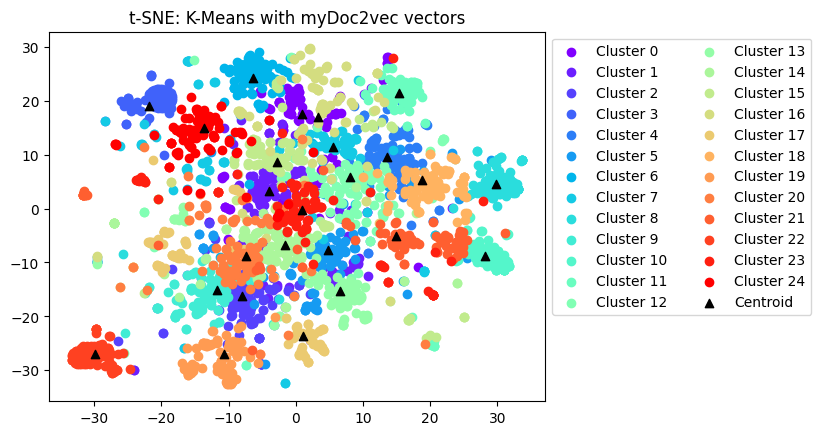

In [19]:
# number of samples per cluster to display
N = 100

# <N> samples of document vectors for each cluster
samples = vec_corpus[
    np.array([np.random.choice(np.where(clusters == k)[0], N) for k in range(K)]).flatten()
]

# documents and centroids as points in a n-dimensional space
points_nD = np.concatenate((samples, centroids))

# t-SNE to reduce the number of dimensions
tsne = TSNE(n_components=2, max_iter=2500, perplexity=100)
points_2D = tsne.fit_transform(points_nD)

# plot the clusters with their centroids
fig = plt.figure()
ax = fig.add_subplot()
colors = plt.cm.rainbow(np.linspace(0, 1, K))
for k, color in enumerate(colors):
    ax.scatter(
        points_2D[k*N:k*N+N, 0], points_2D[k*N:k*N+N, 1],
        alpha=1,
        color=color,
        label=f"Cluster {k}"
    )
ax.scatter(points_2D[-K:, 0], points_2D[-K:, 1], color="black", marker='^', label="Centroid")
plt.title("t-SNE: K-Means with myDoc2vec vectors")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)
plt.show()

## Subject's ...

In [ ]:
# @markdown Minimum and maximum length (in characters) of email bodies to be analyzed:
min_len_cnt =  500  # @param {type: "number"}
max_len_cnt = 5000  # @param {type: "number"}
# @markdown Minimum and maximum length (in characters) of email subjects to be analyzed:
min_len_sbj =   30  # @param {type: "number"}
max_len_sbj =   70  # @param {type: "number"}
# @markdown ---

cnt_corpus = df[df["content"].apply(lambda x: len(x)).between(min_len_cnt, max_len_cnt)]
sbj_corpus = df[df["subject"].apply(lambda x: len(x)).between(min_len_sbj, max_len_sbj)]

In [ ]:
pp = Preprocessor(
    case_sensitive = False,
    lemmatize = True,
    noun_chunks = False,
    keep_stopwords = False,
    extend_stopwords = {"email", "fw", "mail", "hereto", "link", "pm", "re", "recipient", "sender", "thank", "thanks", "thereto", "time"},
    regex_flags = re.IGNORECASE,
    regex_invalid_line = Preprocessor.CREIL.HEADER,
    regex_invalid_tokens = Preprocessor.CREIT.ALPHA_2,
    pos_to_keep = {"ADJ", "NOUN", "VERB"},
    ent_to_rm = {"DATE", "TIME"}
)

tokenized_cnt_corpus = list(cnt_corpus["content"].progress_apply(pp.preprocess))
tokenized_sbj_corpus = list(sbj_corpus["subject"].progress_apply(pp.preprocess))

# create a single corpus to train word2vec containing both email bodies and subjects
tokenized_corpus = tokenized_cnt_corpus + tokenized_sbj_corpus

  0%|          | 0/137431 [00:00<?, ?it/s]

  0%|          | 0/90793 [00:00<?, ?it/s]

### myDoc2vec

In [ ]:
# @markdown If True, the Word2vec model is trained using the corpus, otherwise a pre-trained model is downloaded:
train = True    # @param {type: "boolean"}
# @markdown The norm that must be used:
norm = "l2" # @param ["l1","l2"]
# @markdown Word vector size:
wv_size = 100    # @param {type: "number"}
# @markdown Skip tokens that do not have a relative document frequency in this range:
min_df = 0.01  # @param {type: "number"}
max_df = 1.00  # @param {type: "number"}
# @markdown ---

# compute / download word vectors
word2vector :np.ndarray
if train:
    model = gensim.models.Word2Vec(tokenized_corpus, vector_size=wv_size)
    word2vector = model.wv
else:
    word2vector = gensim.downloader.load("word2vec-google-news-300")

# vectorizer used to compute the tf-idf score
tfidf_vectorizer =  TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, norm=norm, min_df=min_df, max_df=max_df).fit(tokenized_corpus)

# define the vocabolary shared by the word2vect model and the tf-idf vectorizer
count = 0
voc = set(tfidf_vectorizer.get_feature_names_out())
for tk in tfidf_vectorizer.get_feature_names_out():
    if tk not in word2vector.key_to_index:
        voc.remove(tk)
        count += 1
print(f"Tokens removed: {count}")

Tokens removed: 0


In [ ]:
# @markdown Weights formula's parameters:
exp_a = 1.0  # @param {type: "number"}
exp_b = 0.0 # @param {type: "number"}
eps_type = "pc" # @param ["abs", "pc"]
eps = 0.90  # @param {type: "number"}
# @markdown ---

d2v = myDoc2vec(
    word2vector,
    TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, norm=norm, vocabulary=voc),
    exp_a = exp_a,
    exp_b = exp_b,
    eps_type = eps_type,
    eps = eps
)

vec_corpus = d2v.transform(tokenized_sbj_corpus, save=True)

In [ ]:
# random example
idx = np.random.randint(0, len(tokenized_sbj_corpus))

print(f"Random exemple [iloc:{idx}, loc:{sbj_corpus.index[idx]}] =>")
print(f"{sbj_corpus.iloc[idx, 5]}")
print("------------------------------------------")
print(f" - tokenized document: {tokenized_sbj_corpus[idx]}")
print(f" - token weights: {d2v._weights[idx]}")
print(f" - most similar: {d2v.w2v.most_similar(vec_corpus[idx], topn=5)}")

Random exemple [iloc:34984, loc:177258] =>
RE:Enron/Crestar AOS purchase and sale agreement
------------------------------------------
 - tokenized document: ['purchase', 'sale', 'agreement']
 - token weights: {'agreement': 0.31739467685417916, 'purchase': 0.4027474778998449, 'sale': 0.27985784524597607}
 - most similar: [('purchase', 0.8804572224617004), ('sale', 0.8445829749107361), ('purchaser', 0.6545531749725342), ('agreement', 0.619636595249176), ('transaction', 0.6008437275886536)]


### K-Means with myDoc2vec

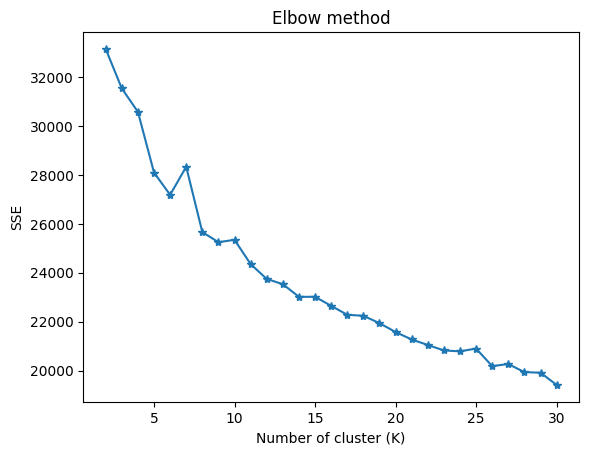

Number of clusters:
 - K:2 => Silhouette coeff.: 0.347369835569694
 - K:3 => Silhouette coeff.: 0.38847890467339646
 - K:4 => Silhouette coeff.: 0.39981031551210655
 - K:5 => Silhouette coeff.: 0.405385658548185
 - K:6 => Silhouette coeff.: 0.42928871486317466
 - K:7 => Silhouette coeff.: 0.43408296581318323
 - K:8 => Silhouette coeff.: 0.39658207547820573 *
 - K:9 => Silhouette coeff.: 0.44153535050816856
 - K:10 => Silhouette coeff.: 0.44616754113777185
 - K:11 => Silhouette coeff.: 0.4576687468544015
 - K:12 => Silhouette coeff.: 0.4634875435831375
 - K:13 => Silhouette coeff.: 0.4656749881678307
 - K:14 => Silhouette coeff.: 0.47474430927802197
 - K:15 => Silhouette coeff.: 0.4823094186043114
 - K:16 => Silhouette coeff.: 0.4792925782411786 *
 - K:17 => Silhouette coeff.: 0.4944804398284876
 - K:18 => Silhouette coeff.: 0.4852722602068961 *
 - K:19 => Silhouette coeff.: 0.48582182324955975
 - K:20 => Silhouette coeff.: 0.4968537659648685
 - K:21 => Silhouette coeff.: 0.503043146403

In [ ]:
# use elbow method and silhouette score to estimate the number of clusters
kmeans = KMeansHelper()

_ = kmeans.elbow_method(vec_corpus, 2, 31)
_ = kmeans.silhouette_score(vec_corpus, 2, 31)

In [ ]:
# number of clusters
K = 25   # PARAM
# number of most similar tokens to show per cluster
W = 5   # PARAM

kmeans = KMeansHelper()
clusters, centroids = kmeans.fit_predict(vec_corpus, K)

# print clusters found
for k in range(K):
    doc_idxs_in_cluster = np.flatnonzero(clusters == k)

    print(f"Cluster {k} =>")
    print(f" - size: {len(doc_idxs_in_cluster)}")
    print(f" - closest tokens: {d2v.w2v.most_similar(centroids[k], topn=W)}")
    print(f" - random samples: {np.random.choice(doc_idxs_in_cluster, 10)}")
print()

Cluster 0 =>
 - size: 1669
 - closest tokens: [('accrue', 0.6877086758613586), ('pay', 0.6829063892364502), ('shortfall', 0.6574487686157227), ('lower', 0.6439416408538818), ('increase', 0.6365117430686951)]
 - random samples: [74165 45063 14592 17602 12020 17235 85558  2622 10302 61716]
Cluster 1 =>
 - size: 44456
 - closest tokens: [('employee', 0.5711281299591064), ('enterprise', 0.5013285279273987), ('company', 0.4825993478298187), ('internet', 0.4485824704170227), ('course', 0.43665969371795654)]
 - random samples: [56877 32309 16634  2360 14862 61450  1916 39308 42779 77020]
Cluster 2 =>
 - size: 2981
 - closest tokens: [('hour', 1.0), ('kilowatt', 0.5699486136436462), ('megawatt', 0.5460013747215271), ('tblloads', 0.5315003991127014), ('mkt_type', 0.5188133120536804)]
 - random samples: [59265 28408 78225 77934 19326 77955 18826 59229 77915 89395]
Cluster 3 =>
 - size: 2379
 - closest tokens: [('document', 0.8385570049285889), ('draft', 0.7825803756713867), ('memo', 0.7147299647

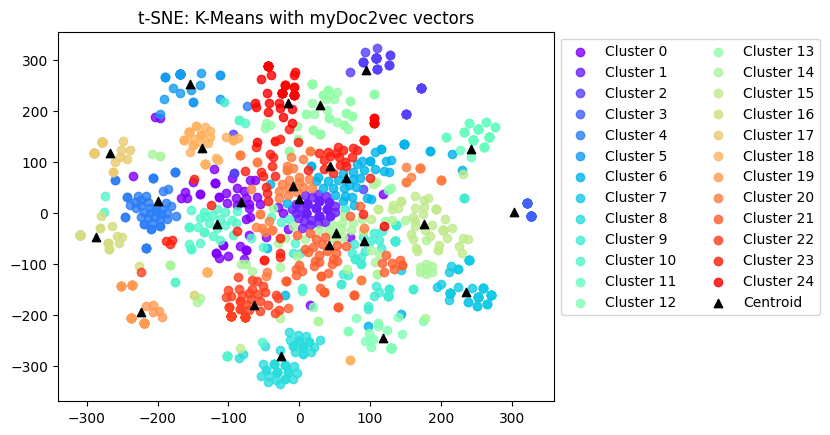

In [ ]:
# number of samples per cluster to display
N = 50

# <N> samples of document vectors for each cluster
samples = vec_corpus[
    np.array([np.random.choice(np.where(clusters == k)[0], N) for k in range(K)]).flatten()
]

# documents and centroids as points in a n-dimensional space
points_nD = np.concatenate((samples, centroids))

# t-SNE to reduce the number of dimensions
tsne = TSNE(n_components=2, max_iter=2000, perplexity=50)
points_2D = tsne.fit_transform(points_nD)

# plot the clusters with their centroids
fig = plt.figure()
ax = fig.add_subplot()
colors = plt.cm.rainbow(np.linspace(0, 1, K))
for k, color in enumerate(colors):
    ax.scatter(
        points_2D[k*N:k*N+N, 0], points_2D[k*N:k*N+N, 1],
        alpha=0.8,
        color=color,
        label=f"Cluster {k}"
    )
ax.scatter(points_2D[-K:, 0], points_2D[-K:, 1], color="black", marker='^', label="Centroid")
plt.title("t-SNE: K-Means with myDoc2vec vectors")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)
plt.show()

## Extra

In [2]:
# -- Read/Save the variables --
import pickle

def write_var(variable, filename):
    with open(filename, 'wb') as f:
        pickle.dump(variable, f)

def read_var(filename):
    with open(filename, 'rb') as f:
        variable = pickle.load(f)
    return variable


#write_var(, ".pkl")
#  = read_var(".pkl")

In [ ]:
# -- Draw samples and save all info --
# 2*<N> is the number of samples per cluster
N = 5
# closest words saved
W = 5

for k in range(K):
    doc_idxs_in_cluster = np.flatnonzero(clusters == k)
    cluster_size = len(doc_idxs_in_cluster)

    dists = 1 - d2v.w2v.cosine_similarities(centroids[k], vec_corpus[doc_idxs_in_cluster])
    argsorted_dists = np.argsort(dists)

    sample_idxs = np.concatenate((
        [argsorted_dists[0]],
        np.random.choice(argsorted_dists[1:cluster_size//2], size=N-1, replace=False),
        np.random.choice(argsorted_dists[cluster_size//2:], size=N, replace=False),
    ))

    samples = doc_idxs_in_cluster[sample_idxs]

    s = f"Cluster {k} =>\n"
    s += f" - size: {cluster_size}\n"
    s += f" - closest tokens: {d2v.w2v.most_similar(centroids[k], topn=W)}\n"
    s += f" - samples: iloc={samples}, loc={[corpus.index[s] for s in samples]}\n"
    s += f" - distances: {[round(d, 3) for d in dists[sample_idxs]]}\n"
    s += f" - closest tokens:\n"
    for sample in samples:
        s += f" - {sample}:{d2v.w2v.most_similar(vec_corpus[sample], topn=W)}\n"
    s += "\n"
    print(s)

    f = open(f"cluster_{k if k >= 10 else '0'+str(k)}.txt", "w")

    f.write(s)
    for sample in samples:
        f.write("\n" + 38*"|#|" + "\n")
        f.write(corpus.iloc[sample, 6])
        f.write("\n" + 38*"|#|" + "\n")
    f.close()